In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [26]:
# Figure out how partial derivatives and gradients work
# def f(x):
#     return tf.math.square(x[0]) + tf.math.square(x[1]) + tf.math.multiply(x[0],x[1]) # x^2+y^2+xy
#
# x_bar = tf.Variable([[1.0,2,3,4],[1,1,1,1]]) # x_bar = (x,y)
# print(x[0])
# with tf.GradientTape() as t:
#     t.watch(x_bar)
#     f = f(x_bar)
# grad_f = t.gradient(f,x_bar)
# df_dx = grad_f[0]
# df_dy = grad_f[1]
# print(grad_f, df_dx, df_dy)
a = tf.constant([1, 2, 3, 4])
b = tf.constant([1, 1, 1, 1])
d = tf.constant([2,2,2,2])
c = tf.stack([a,b,d])
print(c)
c = tf.squeeze(c)
print(c)


tf.Tensor(
[[1 2 3 4]
 [1 1 1 1]
 [2 2 2 2]], shape=(3, 4), dtype=int32)
tf.Tensor(
[[1 2 3 4]
 [1 1 1 1]
 [2 2 2 2]], shape=(3, 4), dtype=int32)


In [28]:
# Construct Model
in_bnd_pts_input = Input(shape=(1,2))
out_bnd_pts_input = Input(shape=(1,2))
int_pts_input = Input(shape=(1,2))

# Inner bound branch
w = Dense(10, activation = 'tanh')(in_bnd_pts_input)
w = Dense(100, activation = 'tanh')(w)
w = Dense(10, activation = 'tanh')(w)
w = Dense(1, activation = 'tanh')(w)
w = Model(inputs = in_bnd_pts_input, outputs = w)

# Outter bound branch
x = Dense(10, activation = 'tanh')(out_bnd_pts_input)
x = Dense(100, activation = 'tanh')(x)
x = Dense(1, activation = 'tanh')(x)
x = Model(inputs = out_bnd_pts_input, outputs = x)

# Interior point branch
y = Dense(10, activation = 'tanh')(int_pts_input)
y = Dense(100, activation = 'tanh')(y)
y = Dense(10, activation = 'tanh')(y)
y = Dense(1, activation = 'tanh')(y)
y = Model(inputs = int_pts_input, outputs = y)

combined = tf.stack([w.output, x.output, y.output], 0)

# Output layer
z = Dense(1, activation = 'linear')(combined)

model = Model(inputs = [w.inputs, x.input, y.input], outputs = z)

In [67]:
def loss_fn(model, in_bnd_pts, out_bnd_pts, int_pts): # loss_fn(model, inner bound points, outer bound points, interior points)
    
    r = int_pts[0]
    theta = int_pts[1]
    #print(tf.shape(in_bnd_pts))
    #print(tf.shape(out_bnd_pts))
    #print(tf.shape(int_pts))
    
    with tf.GradientTape() as t:
        t.watch(int_pts)
        g = model([in_bnd_pts, out_bnd_pts, int_pts])
        #print('g = ', g)
    grad_g = t.gradient(g,int_pts) # Not actual gradient, need polar representation!
    
    dg_dr = grad_g[0] # dg/dr
    dg_dtheta = grad_g[1] # dg/dtheta
    
    grad_g = tf.stack([dg_dr, tf.math.divide(dg_dtheta, r)],0) # grad_g = dg/dr r^ + 1/r dg/dtheta theta^.
    
    dummy_pts = tf.zeros(tf.shape(in_bnd_pts))
    
    in_bnd_error = model([in_bnd_pts, dummy_pts, dummy_pts], training=False) # g(2,theta)-0
    out_bnd_error = tf.subtract(model([dummy_pts, out_bnd_pts, dummy_pts], training=False),tf.math.scalar_mul
                                (4,tf.sin(tf.math.scalar_mul(5,out_bnd_pts[1])))) # g(4,theta)-4sin(5theta)
    
    grad_g_l2_norm = tf.math.scalar_mul(2,tf.nn.l2_loss(grad_g)) # Dirichlet energies
    in_bnd_mse = tf.math.scalar_mul(2,tf.nn.l2_loss(in_bnd_error)) # MSE inner bound points
    out_bnd_mse = tf.math.scalar_mul(2,tf.nn.l2_loss(out_bnd_error)) # MSE outer bound points

    Lambda = 100
    
    weighted_bnd_loss = tf.math.scalar_mul(Lambda, tf.math.add(in_bnd_mse,out_bnd_mse)) # weight boundary conditions
    
    loss = tf.math.add(grad_g_l2_norm,weighted_bnd_loss)
    
    return loss

In [68]:
def train_for():
    # Train network
    optimizer = tf.keras.optimizers.Adam() # Fancy gradient decent
    epochs = 100
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    in_bnd_pts_size = 1000 # Number of inner boundary points to sample each iteration
    out_bnd_pts_size = 1000 # Number of outer boundary points to sample each iteration
    int_pts_size = 1000 # Number of interior points to sample each iteration

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            
            r_in_bnd_pts = tf.math.scalar_mul(2,tf.ones([1,in_bnd_pts_size]))
            theta_in_bnd_pts = tf.random.uniform([1,in_bnd_pts_size], maxval=2*np.pi)
            in_bnd_pts = tf.transpose(tf.stack([r_in_bnd_pts,theta_in_bnd_pts]))
            #print(tf.shape(in_bnd_pts)) # Random inner bound points
            
            r_out_bnd_pts = tf.math.scalar_mul(4,tf.ones([1,out_bnd_pts_size]))
            theta_out_bnd_pts = tf.random.uniform([1,out_bnd_pts_size], maxval=2*np.pi)
            out_bnd_pts = tf.transpose(tf.stack([r_out_bnd_pts, theta_out_bnd_pts]))
            #print(tf.shape(out_bnd_pts)) # Random outer bound points
            
            r_int_pts = tf.random.uniform([1,int_pts_size], minval=2, maxval=4)
            theta_int_pts = tf.random.uniform([1,int_pts_size], maxval = 2*np.pi)
            int_pts = tf.transpose(tf.stack([r_int_pts,theta_int_pts]))
            #print(tf.shape(int_pts)) # Random interior points
            
            stacked_inputs = tf.stack([in_bnd_pts, out_bnd_pts, int_pts])
            
            with tf.GradientTape() as t:
                t.watch(stacked_inputs)
                #print(x)
                #f = model(x, training=True) # Estimate for u
                loss = loss_fn(model, in_bnd_pts, out_bnd_pts, int_pts) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [69]:
train_for()

Epoch 000: Loss: 4623973.500
Epoch 001: Loss: 4721010.500
Epoch 002: Loss: 4541698.000
Epoch 003: Loss: 4566684.000
Epoch 004: Loss: 4513357.500
Epoch 005: Loss: 5270075.500
Epoch 006: Loss: 4916416.000
Epoch 007: Loss: 4991951.500
Epoch 008: Loss: 4327698.500
Epoch 009: Loss: 4703855.500
Epoch 010: Loss: 4193176.000
Epoch 011: Loss: 4948780.500
Epoch 012: Loss: 4338665.500
Epoch 013: Loss: 5117481.000
Epoch 014: Loss: 4705724.000
Epoch 015: Loss: 4634796.000
Epoch 016: Loss: 4541328.500
Epoch 017: Loss: 4422785.000
Epoch 018: Loss: 4852531.500
Epoch 019: Loss: 4107172.250
Epoch 020: Loss: 4707243.500
Epoch 021: Loss: 5016754.000
Epoch 022: Loss: 4924730.000
Epoch 023: Loss: 4557725.500
Epoch 024: Loss: 5058766.000
Epoch 025: Loss: 4262706.000
Epoch 026: Loss: 4919061.000
Epoch 027: Loss: 4502945.500
Epoch 028: Loss: 5181265.000
Epoch 029: Loss: 5071593.500
Epoch 030: Loss: 4902611.000
Epoch 031: Loss: 4755617.000
Epoch 032: Loss: 4281345.500
Epoch 033: Loss: 4549023.500
Epoch 034: Los

In [74]:
in_bnd_pts_size = 1000 # Number of inner boundary points to sample 
out_bnd_pts_size = 1000 # Number of outer boundary points to sample 
int_pts_size = 1000 # Number of interior points to sample

r_in_bnd_pts = tf.math.scalar_mul(2,tf.ones([1,in_bnd_pts_size]))
#print(tf.shape(r_in_bnd_pts))
theta_in_bnd_pts = tf.random.uniform([1,in_bnd_pts_size], maxval=2*np.pi)
#print(tf.shape(theta_in_bnd_pts))
in_bnd_pts = tf.transpose(tf.stack([r_in_bnd_pts,theta_in_bnd_pts]))
#print(tf.shape(in_bnd_pts)) # Random inner bound points

r_out_bnd_pts = tf.math.scalar_mul(4,tf.ones([1,out_bnd_pts_size]))
theta_out_bnd_pts = tf.random.uniform([1,out_bnd_pts_size], maxval=2*np.pi)
out_bnd_pts = tf.transpose(tf.stack([r_out_bnd_pts, theta_out_bnd_pts]))
#print(tf.shape(out_bnd_pts)) # Random outer bound points

r_int_pts = tf.random.uniform([1,int_pts_size], minval=2, maxval=4)
theta_int_pts = tf.random.uniform([1,int_pts_size], maxval = 2*np.pi)
int_pts = tf.transpose(tf.stack([r_int_pts,theta_int_pts]))
#print(tf.shape(int_pts)) # Random interior points

test_pts = model([in_bnd_pts, out_bnd_pts, int_pts])
#print(test_pts[0],test_pts[1])
#print(tf.shape(test_pts))
#print(max(test_pts),min(test_pts))
test_pts = tf.squeeze(test_pts)
#print(tf.shape(test_pts))

test_in_bnd_pts = test_pts[0,0:] # Model of inner bound
#print(test_in_bnd_pts)
test_out_bnd_pts = test_pts[1,0:] # Model of outer bound
#print(test_out_bnd_pts)
test_int_pts = test_pts[2,0:] # Model of interior
#print(test_int_pts)

(3000,)
(3000,)
tf.Tensor([3000], shape=(1,), dtype=int32)


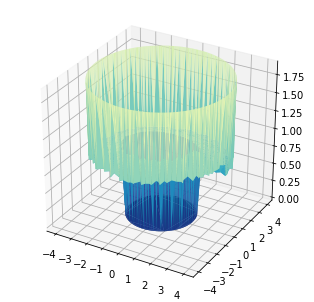

In [75]:
fig = pylab.figure(figsize=plt.figaspect(.96))
ax = Axes3D(fig)

r_plt_pts = tf.concat([r_in_bnd_pts, r_out_bnd_pts, r_int_pts], 1)  
r = r_plt_pts.numpy()[0]
print(r.shape)
theta_plt_pts = tf.concat([theta_in_bnd_pts, theta_out_bnd_pts, theta_int_pts], 1)
theta = theta_plt_pts.numpy()[0]
print(theta.shape)

z_plt_pts = tf.concat([test_in_bnd_pts, test_out_bnd_pts, test_int_pts], 0)
print(tf.shape(z_plt_pts))
z = z_plt_pts.numpy()

#print(z)

x, y = r*np.cos(theta), r*np.sin(theta)


ax.plot_trisurf(x,y,z, cmap=plt.cm.YlGnBu_r)
plt.show()